In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np

Train a deep MLP on the MNIST dataset (you can load it using
tf.keras.datasets.mnist.load_data()). See if you can get over
98% accuracy by manually tuning the hyperparameters. Try searching
for the optimal learning rate by using the approach presented in this
chapter (i.e., by growing the learning rate exponentially, plotting the
loss, and finding the point where the loss shoots up). Next, try tuning
the hyperparameters using Keras Tuner with all the bells and whistles
—save checkpoints, use early stopping, and plot learning curves using
TensorBoard.


### Load the data

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = datasets.mnist.load_data()

In [3]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [4]:
X_test = X_test / 255.

(-0.5, 27.5, 27.5, -0.5)

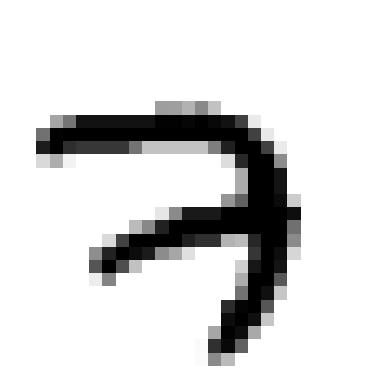

In [5]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')

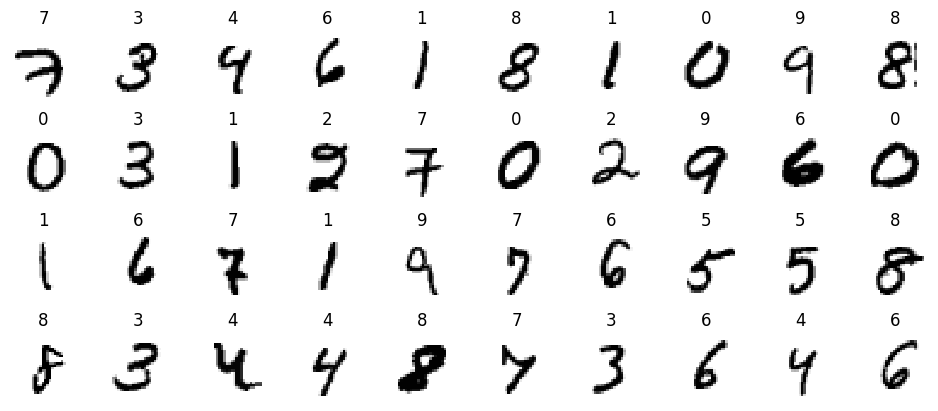

In [29]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [71]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []

  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.learning_rate))
    self.losses.append(logs["loss"])
    K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  tf.keras.layers.Dense(300, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax")
])

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [82]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
expon_lr = ExponentialLearningRate(factor=1.005)

In [84]:
history = model.fit(
    X_train, y_train, epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[expon_lr]
)

1719/1719 [==============================] - 10s 5ms/step - loss: nan - accuracy: 0.5914 - val_loss: nan - val_accuracy: 0.0958


In [93]:
min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates)

(1.002311110496521, 0.001, 5.2636895)

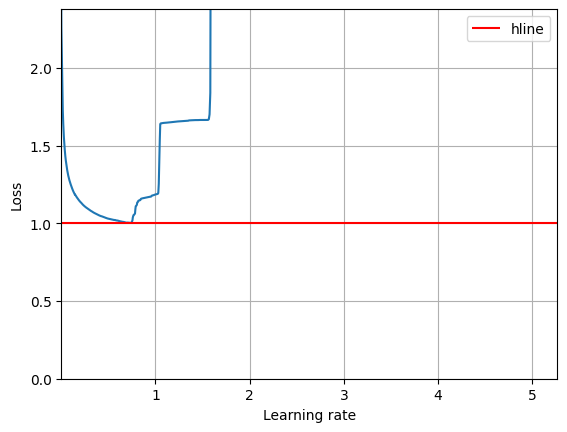

In [142]:
plt.plot(expon_lr.rates, expon_lr.losses)
#plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates), "r", label="hline")
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.legend()

In [138]:
len(expon_lr.losses)

1719

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [9]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("Models/mnist_model.keras", save_best_only=True)

history = model.fit(
    X_train, y_train, epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2330 - accuracy: 0.9272 - val_loss: 0.1120 - val_accuracy: 0.9686
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0952 - accuracy: 0.9708 - val_loss: 0.1073 - val_accuracy: 0.9694
Epoch 3/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0658 - accuracy: 0.9782 - val_loss: 0.0838 - val_accuracy: 0.9768
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.0801 - val_accuracy: 0.9772
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0362 - accuracy: 0.9880 - val_loss: 0.0918 - val_accuracy: 0.9768
Epoch 6/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0267 - accuracy: 0.9914 - val_loss: 0.0823 - val_accuracy: 0.9804
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.0756 - val_ac

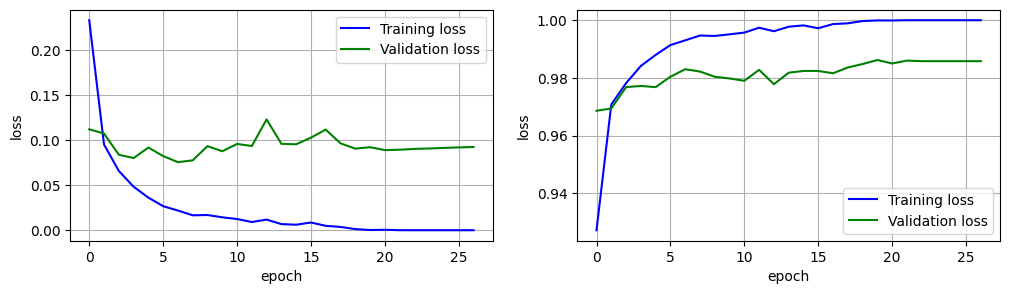

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

plt.sca(axes[0])
plt.plot(history.epoch, history.history["loss"], "b", label="Training loss")
plt.plot(history.epoch, history.history["val_loss"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

plt.sca(axes[1])
plt.plot(history.epoch, history.history["accuracy"], "b", label="Training loss")
plt.plot(history.epoch, history.history["val_accuracy"], "g", label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0872 - accuracy: 0.9848


[0.08722618222236633, 0.9847999811172485]

In [27]:
model = keras.models.load_model("Models/mnist_model.keras")
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0746 - accuracy: 0.9802


[0.0745752602815628, 0.9801999926567078]